
# Using the GLM for Classification
In this notebook we test the GLM for binary classification on the USPS handwritten digits dataset. We compare to select models in scikit learn too.

In [9]:
%matplotlib inline
import logging
import numpy as np
import matplotlib.pyplot as pl
pl.style.use('ggplot')
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss, accuracy_score

from revrand.utils.datasets import fetch_gpml_usps_resampled_data
from revrand import GeneralisedLinearModel
from revrand.btypes import Parameter, Positive
from revrand.basis_functions import RandomMatern52, BiasBasis
from revrand.likelihoods import Bernoulli
from revrand.optimize import AdaDelta, Adam

# Log output to the terminal attached to this notebook
import logging
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)


### Settings

In [10]:
# Which digits to classify
dig1 = 3
dig2 = 5

# Algorith settings
nbases = 50
lenscale = 10.
regulariser = 1
maxiter = 3000
batch_size = 10
updater = AdaDelta()

# Bounded variables
regulariser_init = Parameter(regulariser, Positive())
lenscale_init = Parameter(lenscale, Positive())


# Feature Transform
basis = RandomMatern52(nbases, 256, lenscale_init=lenscale_init) \
    + BiasBasis()

### Get and load data

In [11]:
# Fetch/load
usps_resampled = fetch_gpml_usps_resampled_data()

# Training dataset
ind_fals = usps_resampled.train.targets == dig1
ind_true = usps_resampled.train.targets == dig2
ind_all = np.logical_or(ind_fals, ind_true) 

X = usps_resampled.train.data[ind_all]
Y = (usps_resampled.train.targets[ind_all] == dig2).astype(float)

# Test dataset
ind_fals = usps_resampled.test.targets == dig1
ind_true = usps_resampled.test.targets == dig2
ind_all = np.logical_or(ind_fals, ind_true) 

Xs = usps_resampled.test.data[ind_all]
Ys = (usps_resampled.test.targets[ind_all] == dig2).astype(float)


### Classify using *revrand*

In [12]:
llhood = Bernoulli()
glm = GeneralisedLinearModel(llhood,
                             basis,
                             regulariser=regulariser_init,
                             maxiter=maxiter,
                             batch_size=batch_size,
                             updater=updater
                            )
glm.fit(X, Y)

# Predict
pys_l = glm.predict(Xs)
pys_l = np.vstack((1 - pys_l, pys_l)).T
Eys_l = pys_l[:, 0] > 0.5


### Classify using *Scikit Learn*

In [13]:
lreg = LogisticRegression(penalty='l2', class_weight='balanced')
lreg.fit(basis.transform(X, lenscale), Y)
pys_r = lreg.predict_proba(basis.transform(Xs, lenscale))
Eys_r = 1 - lreg.predict(basis.transform(Xs, lenscale))


### Score results

In [14]:
print("GLM: av log loss = {:.6f}, error rate = {:.6f}"
      .format(log_loss(Ys, pys_l), accuracy_score(Ys, Eys_l)))

print("Logistic Scikit: av log loss = {:.6f}, error rate = {:.6f}"
      .format(log_loss(Ys, pys_r), accuracy_score(Ys, Eys_r)))


GLM: av log loss = 0.193868, error rate = 0.065977
Logistic Scikit: av log loss = 0.231809, error rate = 0.067270


### GLM optimisation summary

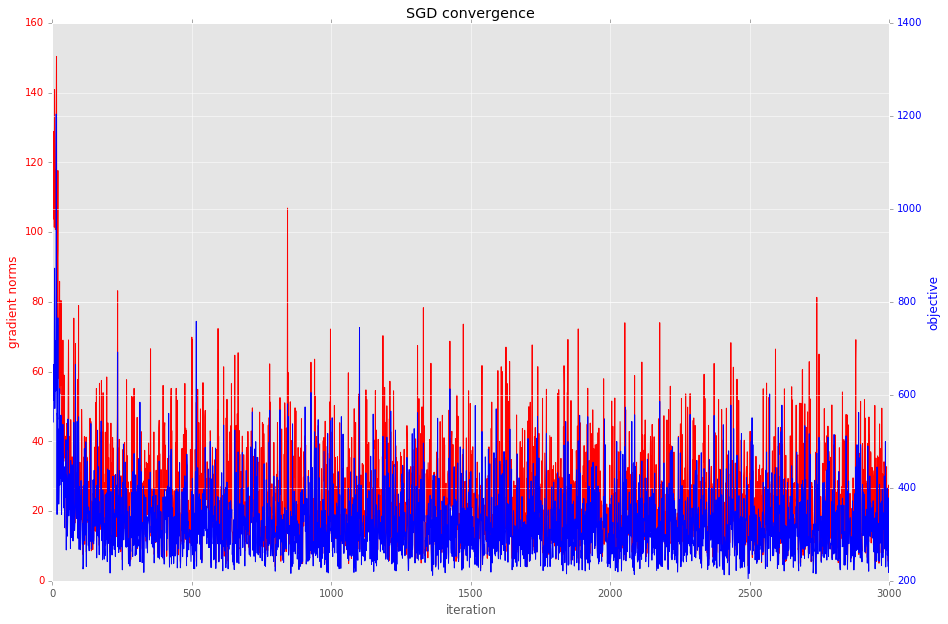

In [15]:
fig = pl.figure(figsize=(15, 10))
ax = fig.add_subplot(111)
pl.xlabel('iteration')

pl.title('SGD convergence')
ax.plot(range(maxiter), glm.grad_trace, 'r')
ax.set_ylabel('gradient norms', color='r')


for t in ax.get_yticklabels():
    t.set_color('r')

ax2 = ax.twinx()
ax2.plot(range(maxiter), glm.obj_trace, 'b')
ax2.set_ylabel('objective', color='b')

for t in ax2.get_yticklabels():
    t.set_color('b')
    
pl.show()


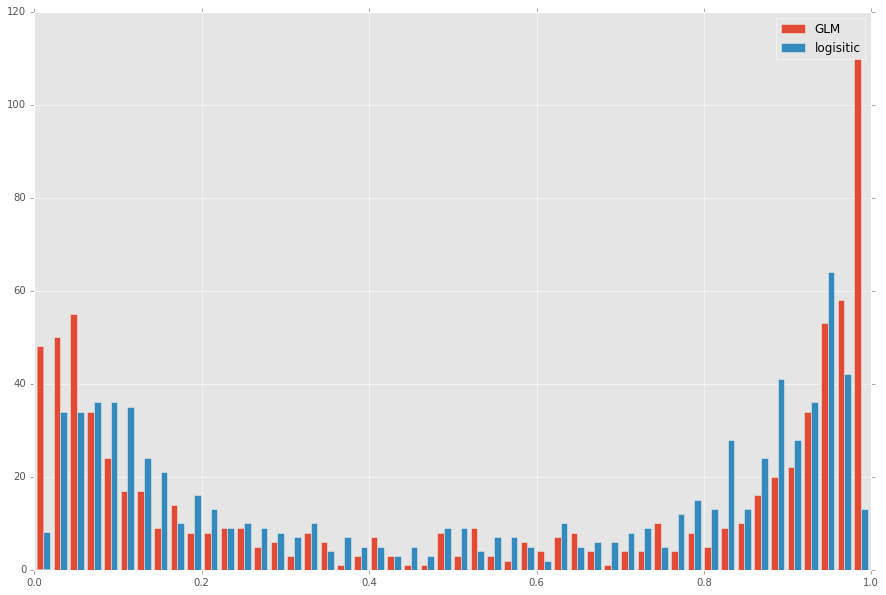

In [16]:
Ns = len(Xs)
pl.figure(figsize=(15, 10))
pl.hist([pys_l[:, 0], pys_r[:, 0]], 50, label=['GLM', 'logisitic'])
pl.legend()
pl.show()
